In [1]:
input_dim = 4
num_clusters = 4
num_classes = 3

ntrials = 10
lg = 2.0 #lambda_global

model_file = "/home/gregory/Desktop/ELDR/Iris-modified/Model/model/perplexity_10_regularizer_0.001_batch_size_191_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"

import csv
import json
import numpy as np
import os
import pandas as pd

os.system("rm *.png")

import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from load_scvis import load_vae
from metrics import metrics, eval_epsilon
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation, plot_similarity
from misc import poly2labels

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# Load Data & Configuration

x = pd.read_csv("../Iris/Data/X_corrupted.tsv", sep="\t").values

labels = pd.read_csv("../Iris/Data/labels_corrupted.tsv", sep="\t").values


In [3]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris-modified/Model/model/perplexity_10_regularizer_0.001_batch_size_191_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


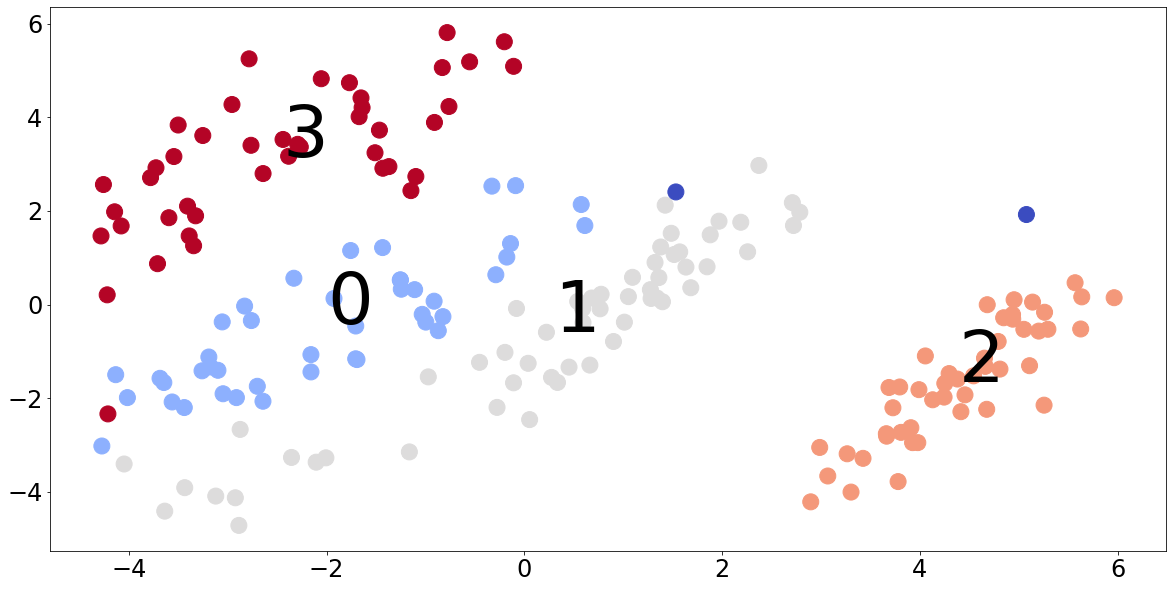

In [4]:
# Visualize the clusters in the learned representation

means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "iris-retrained-rep.png")


In [5]:
# Set epsilon for our metrics

epsilon = 1.0

if True:
    eval_epsilon(load_model, x, indices, epsilon)


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris-modified/Model/model/perplexity_10_regularizer_0.001_batch_size_191_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


In [6]:
# Compute the group explanations

best_val = 0.0
for i in range(ntrials):
    deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
    a, b = metrics(load_model, x, indices, deltas, epsilon)
    
    val = np.mean(a)
    
    if val > best_val:
        best_val = val
        np.save("deltas.npy", deltas)
    
    os.system("rm -rf explanation")

                    

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris-modified/Model/model/perplexity_10_regularizer_0.001_batch_size_191_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt



INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris-modified/Model/model/perplexity_10_regularizer_0.001_batch_size_191_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris-modified/Model/model/perplexity_10_regularizer_0.001_batch_size_191_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris-modified/Model/model/perplexity_10_regularizer_0.001_batch_size_191_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris-modified/Model/model/perplexity_10_regularizer_0.001_ba

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris-modified/Model/model/perplexity_10_regularizer_0.001_batch_size_191_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


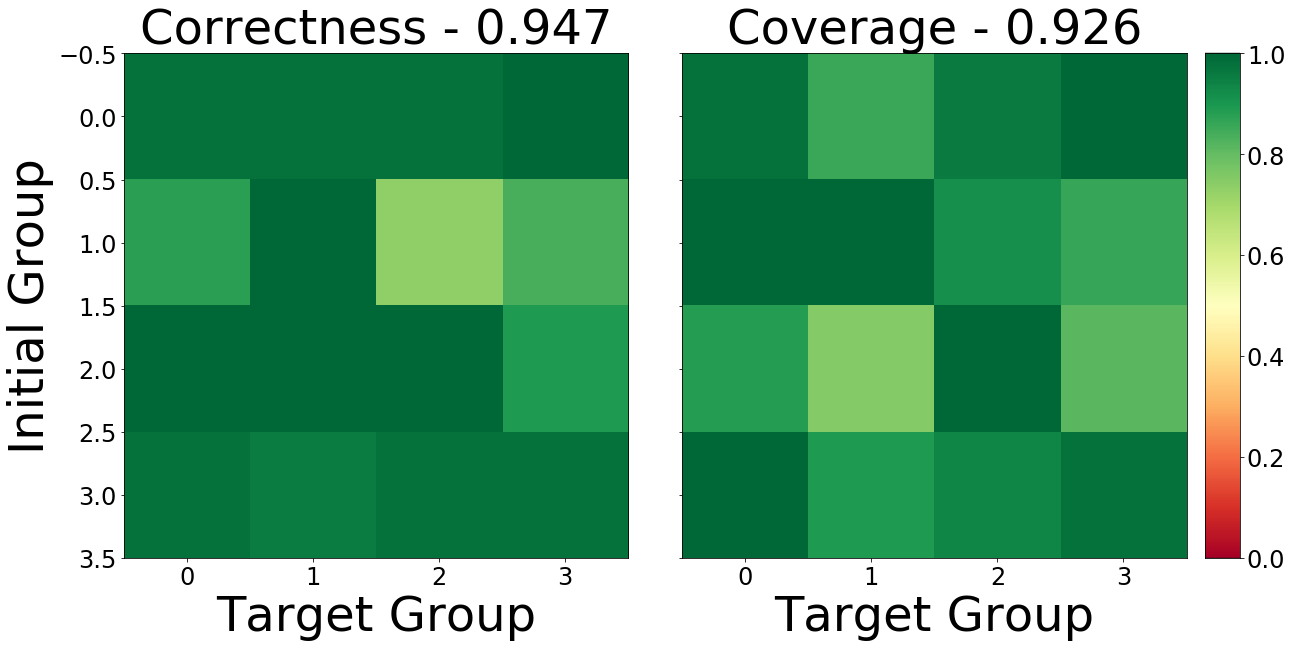

In [7]:
# Evaluate the explanations

deltas = np.load("deltas.npy")

a, b = metrics(load_model, x, indices, deltas, epsilon)

plot_metrics(a, b, name = "iris-retrained-metrics.png")


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris-modified/Model/model/perplexity_10_regularizer_0.001_batch_size_191_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris-modified/Model/model/perplexity_10_regularizer_0.001_batch_size_191_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


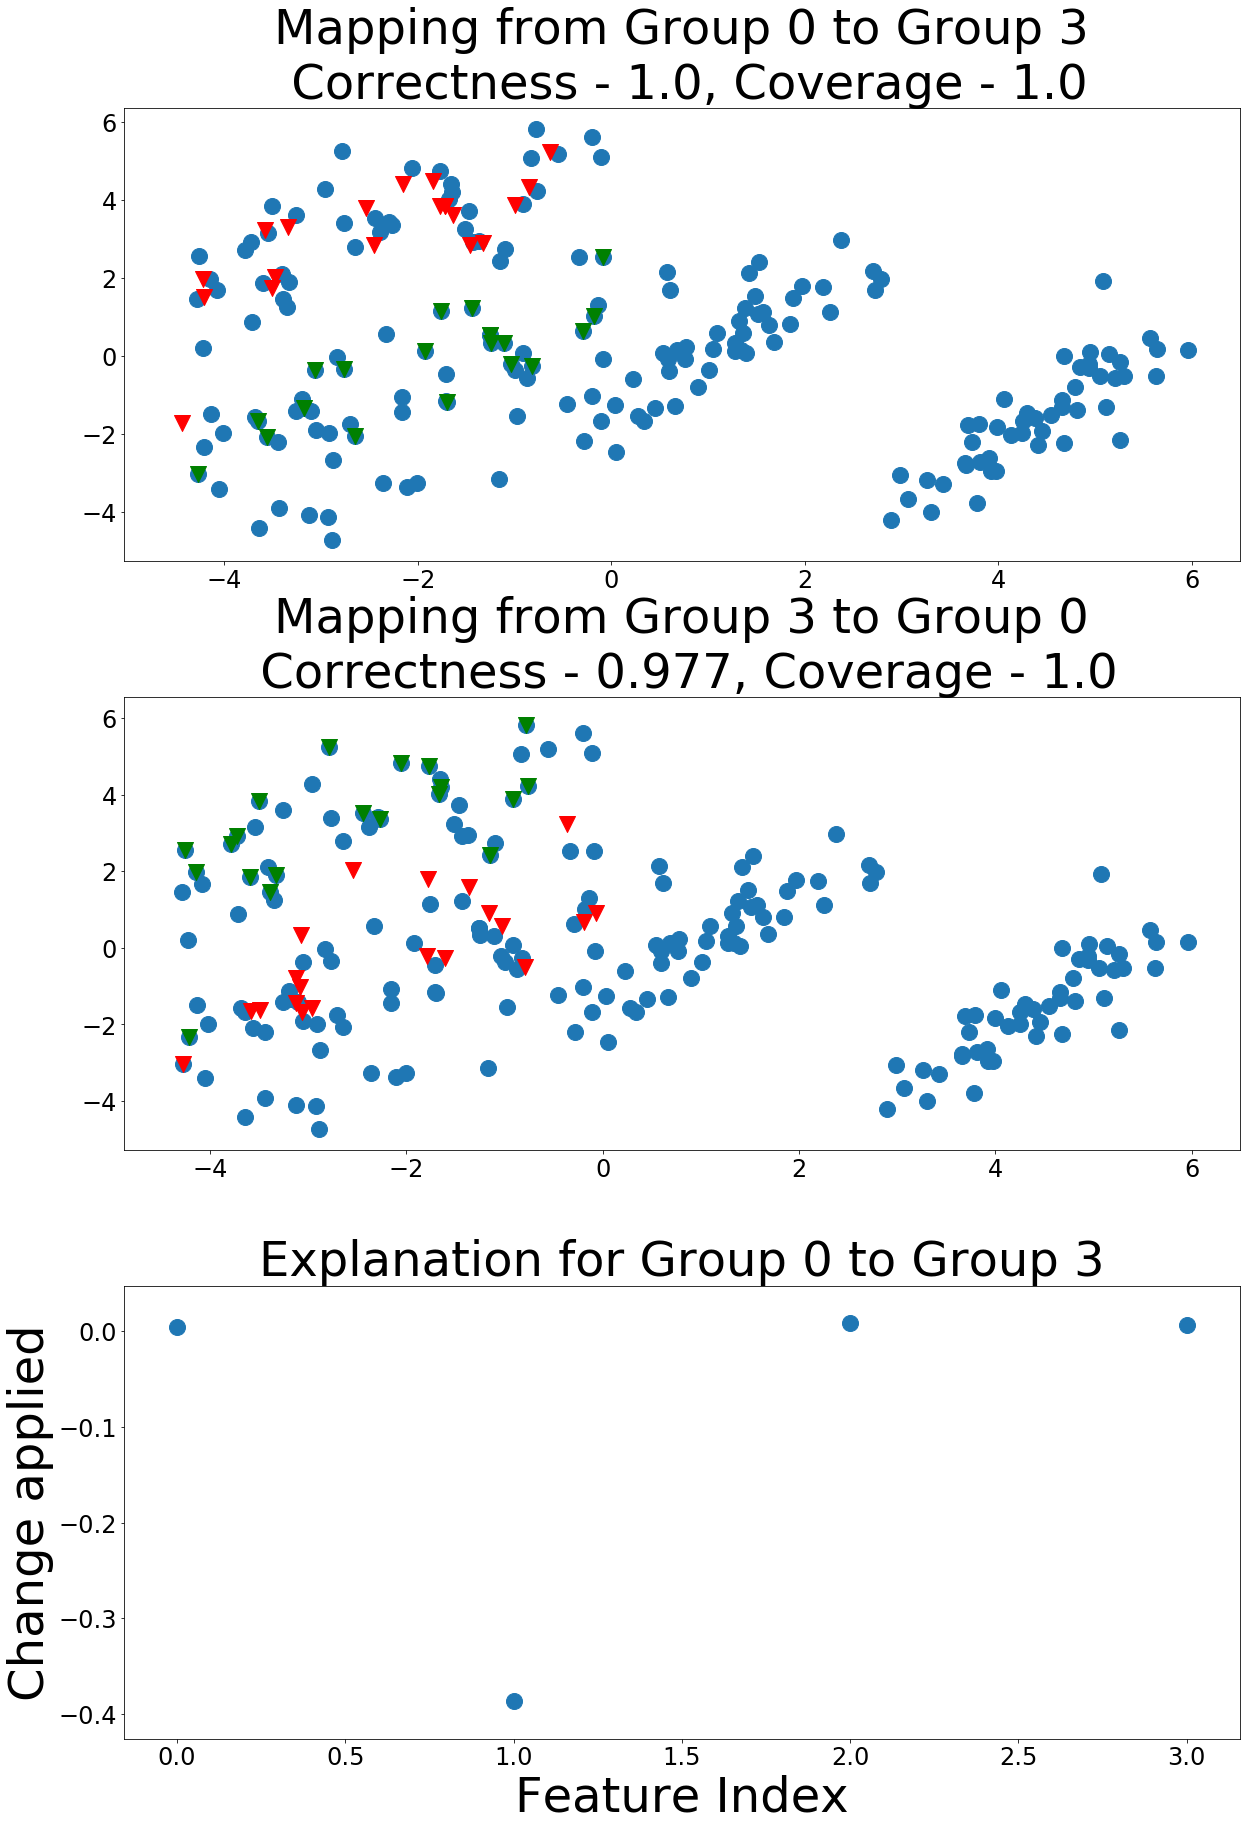

In [8]:
# Visualize the group explanations


plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 0, 3, name = "iris-retrained-t2c.png", num_points = 20)


[[-0.06  0.06 -0.06 -0.3 ]
 [-0.36  0.22 -0.08 -0.9 ]]
[[-0.    0.05 -0.01 -0.27]
 [-0.32  0.21 -0.51 -0.8 ]]


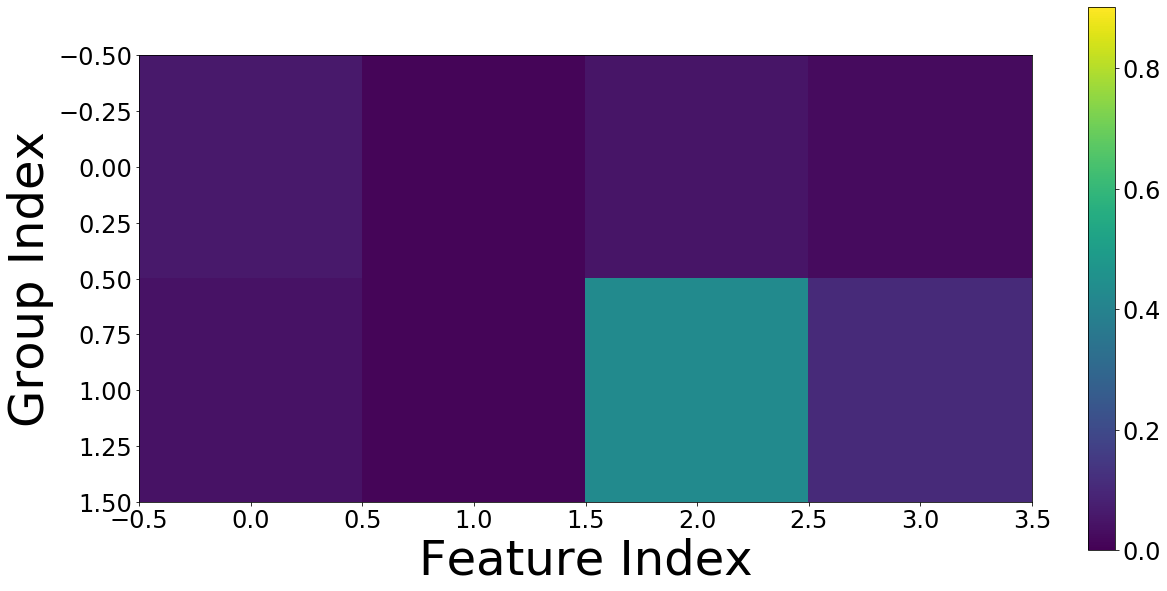

In [9]:
# Evaluate how much the other explanations changed

deltas_original = np.load("../Iris/deltas.npy")

plot_similarity(deltas, deltas_original, "iris-retrained-similarity.png")
